<a href="https://colab.research.google.com/github/gsc16/MachineLearning/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv 
import pandas as pd
import string
import numpy as np
import re
import sys
import time

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

import warnings 
warnings.filterwarnings(action = 'ignore') 

import gensim 
from gensim.models import Word2Vec 

from keras.layers import Dense, Input, LSTM,GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

!pip install symspellpy
from symspellpy.symspellpy import SymSpell
import os
!wget https://github.com/mammothb/symspellpy/blob/master/symspellpy/frequency_dictionary_en_82_765.txt?raw=true \
  -O freq_dict.txt
  
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
--2019-04-25 16:12:14--  https://github.com/mammothb/symspellpy/blob/master/symspellpy/frequency_dictionary_en_82_765.txt?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mammothb/symspellpy/raw/master/symspellpy/frequency_dictionary_en_82_765.txt [following]
--2019-04-25 16:12:14--  htt

In [ ]:
TRAIN_DATA_FILE = 'train.csv'
TEST_DATA_FILE = 'test.csv'

train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[list_classes].values
y_test = test_df[list_classes].values

sentences_train = train_df["comment_text"].fillna("").values
sentences_test = test_df["comment_text"].fillna("").values

In [ ]:
def basic_preprocess(sentences, labels, min_len=5, max_len=200):
  data_sentences = [re.sub(r'[^a-zA-Z ]', '', sentence).lower() for 
                    sentence in sentences]
  
  data_sentences = [sentence.split() for sentence in data_sentences]
  
  small_len = 10000000
  large_len = -1

  remove_index = [i for i in range(len(data_sentences)) if 
                  (len(data_sentences[i]) < min_len or 
                   len(data_sentences[i]) > max_len)]

  data_sentences = np.delete(data_sentences, remove_index, 0)
  data_labels = np.delete(labels, remove_index, 0)

  for sentence in data_sentences:
    sent_len = len(sentence)

    small_len = small_len if sent_len > small_len else sent_len
    large_len = large_len if sent_len < large_len else sent_len

  print(len(data_sentences))

  return data_sentences, data_labels

sentences_train, y_train = basic_preprocess(sentences_train, y_train)
sentences_test, y_test = basic_preprocess(sentences_test, y_test)

data_words = np.concatenate((sentences_train, sentences_test))
data = [' '.join(sentence) for sentence in data_words]
data_spell = data

36268
18007


In [ ]:
max_ed = 2
# create object
sym_spell = SymSpell(max_ed, 7)

if not sym_spell.load_dictionary("freq_dict.txt", 0, 1):
  print("Dictionary file not loaded.")

start = time.time()

for i in range(len(data)):
  data[i] = sym_spell.lookup_compound(data[i], max_ed)[0].term
  end = time.time()
  if(i%1000 == 0):
    print("Spell-checked %d sentences. %.2f minutes passed so far." % (i+1, (end - start)/60))

end = time.time()

print("\nSpell-checking of %d words finished in %.2f minutes" % (i+1, (end - start)/60))


Spell-checked 1 sentences. 0.00 minutes passed so far.
Spell-checked 1001 sentences. 1.43 minutes passed so far.
Spell-checked 2001 sentences. 2.65 minutes passed so far.
Spell-checked 3001 sentences. 3.71 minutes passed so far.
Spell-checked 4001 sentences. 4.83 minutes passed so far.
Spell-checked 5001 sentences. 5.97 minutes passed so far.
Spell-checked 6001 sentences. 7.12 minutes passed so far.
Spell-checked 7001 sentences. 8.15 minutes passed so far.
Spell-checked 8001 sentences. 9.28 minutes passed so far.
Spell-checked 9001 sentences. 10.58 minutes passed so far.
Spell-checked 10001 sentences. 11.90 minutes passed so far.
Spell-checked 11001 sentences. 13.58 minutes passed so far.
Spell-checked 12001 sentences. 15.30 minutes passed so far.
Spell-checked 13001 sentences. 17.14 minutes passed so far.
Spell-checked 14001 sentences. 18.75 minutes passed so far.
Spell-checked 15001 sentences. 20.33 minutes passed so far.
Spell-checked 16001 sentences. 21.96 minutes passed so far.
Sp

In [ ]:
data_words = [sentence.split() for sentence in data]

In [ ]:
def get_pos(part):
    tag = part[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

start = time.time()
lem = WordNetLemmatizer()

for i in range(len(data_words)):
  data_pos = nltk.pos_tag(data_words[i])
  data_words[i] = [lem.lemmatize(w[0], get_pos(w[1])) for w in data_pos]
  
  if i%10000 == 0:
    print("Lemmatized %d sentences so far."%(i+1))

print("\nLemmatizing of %d sentences finished in %.2f minutes" % 
      (i+1, (time.time() - start)/60))

data = [' '.join(sentence) for sentence in data_words]

Lemmatized 1 sentences so far.
Lemmatized 10001 sentences so far.
Lemmatized 20001 sentences so far.
Lemmatized 30001 sentences so far.
Lemmatized 40001 sentences so far.
Lemmatized 50001 sentences so far.

Lemmatizing of 54275 sentences finished in 2.12 minutes
Lemmatized 1 sentences so far.
Lemmatized 10001 sentences so far.
Lemmatized 20001 sentences so far.
Lemmatized 30001 sentences so far.
Lemmatized 40001 sentences so far.
Lemmatized 50001 sentences so far.

Lemmatizing of 54275 sentences finished in 2.12 minutes


In [ ]:
# Fpr Running this program over and over
df = pd.DataFrame(data = data, columns=['comment_text'])
df.to_csv('processed_input.csv', index=False,header=True)

df = pd.DataFrame(data = y_test, columns=list_classes)
df.to_csv('test_labels.csv',index=False,header=True)

df = pd.DataFrame(data = y_train, columns=list_classes)
df.to_csv('train_labels.csv',index=False,header=True)

In [ ]:
test_load = pd.read_csv('test_labels.csv')
train_load = pd.read_csv('train_labels.csv')
data_load =  pd.read_csv('processed_input.csv')
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_train = train_load[list_classes].values
y_test = test_load[list_classes].values

data = data_load["comment_text"].fillna("").values
data_words = [sentence.split() for sentence in data]

# Remove stopwords

'''filter_words = set(stopwords.words('english')) 
for row in range(len(data_words)):
  data_words[row] = [w for w in data_words[row] if not w in filter_words]'''
  
data = [' '.join(sentence) for sentence in data_words]

In [ ]:
vec_size = 200
model1 = gensim.models.Word2Vec(data_words, min_count = 15,  
                              size = vec_size)
vectors = model1.wv

In [ ]:
vectors.most_similar("stupid")

[('dumb', 0.7681975364685059),
 ('fucking', 0.7192113399505615),
 ('crazy', 0.7024043798446655),
 ('sad', 0.69004225730896),
 ('pathetic', 0.6896001100540161),
 ('funny', 0.6853489875793457),
 ('damn', 0.6623865365982056),
 ('ignorant', 0.6603406667709351),
 ('lazy', 0.6532288789749146),
 ('rude', 0.6487330198287964)]

In [ ]:
avg_len = 0
highest_len = -1
for sentence in data_words:
  sent_len = len(sentence)
  avg_len+=len(sentence)
  if(sent_len > highest_len):
    highest_len = sent_len

highest_len
  

285

In [ ]:
# Convert the list of sentences to a list of number sequences,
# where each number is a unique identifier to a word.
seq_limit = 100

tokenizer = Tokenizer(num_words= 100000)
tokenizer.fit_on_texts(data)

data_seq = tokenizer.texts_to_sequences(data)
data_pad = pad_sequences(data_seq, maxlen=seq_limit)



In [ ]:
num_train = len(y_train)
num_test = len(y_test)
shuffled_i = np.random.permutation(num_train)
x_train = data_pad[:num_train]
x_train = x_train[shuffled_i]
y_train = y_train[shuffled_i]

shuffled_i_2 = np.random.permutation(num_test)
x_test = data_pad[num_train:]
x_test = data_pad[shuffled_i_2]
y_test = y_test[shuffled_i_2]

In [ ]:
index_dict = tokenizer.word_index

print("Total number of words: %d"% len(index_dict))

num_words = min(150000, len(index_dict))+1
embed_matrix = np.zeros((num_words, vec_size))
num_wrong = []

for word, index in index_dict.items():
    if word in vectors:
      embed_matrix[index] = vectors[word]
    else:
      num_wrong.append(word)
print('Num of null embeddings: %d' % np.sum(np.sum(embed_matrix, axis=1) == 0))

embed_layer = Embedding(num_words,
                        vec_size,
                        weights=[embed_matrix],
                        input_length=seq_limit,
                        trainable=False,
                        mask_zero = True)

Total number of words: 36629
Num of null embeddings: 29838


In [ ]:
def plot_graphs(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # training and validation accuracy

  plt.plot(epochs, acc, 'r', label='training acc')
  plt.plot(epochs, val_acc, 'b', label='validation acc')
  plt.title('Training/Validation accuracy')
  plt.legend()

  plt.figure()

  # training and validation loss

  plt.plot(epochs, loss, 'r', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.title('Training/Validation loss')
  plt.legend()

  plt.show()


In [ ]:
gru_model = Sequential()
gru_model.add(embed_layer)
gru_model.add(Bidirectional(GRU(100, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
gru_model.add(Dense(6, activation="sigmoid"))
gru_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

gru_model.summary()

history_gru = gru_model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data = (x_test,y_test));

predictions_gru = gru_model.predict(x_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          7326000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               180600    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 7,507,806
Trainable params: 181,806
Non-trainable params: 7,326,000
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 36268 samples, validate on 18007 samples
Epoch 1/5
36268/36268 [==============================] - 225s 6ms/step - loss: 0.1508 - acc: 0.9408 - val

In [ ]:
lstm_model = Sequential()
lstm_model.add(embed_layer)
lstm_model.add(Bidirectional(LSTM(100, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
lstm_model.add(Dense(6, activation="sigmoid"))
lstm_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.summary()

history_lstm = lstm_model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test,y_test));

predictions_lstm = lstm_model.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          7326000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1206      
Total params: 7,568,006
Trainable params: 242,006
Non-trainable params: 7,326,000
_________________________________________________________________
Train on 36268 samples, validate on 18007 samples
Epoch 1/5
36268/36268 [==============================] - 286s 8ms/step - loss: 0.1527 - acc: 0.9395 - val_loss: 0.6733 - val_acc: 0.7925
Epoch 2/5
36268/36268 [==============================] - 286s 8ms/step - loss: 0.1233 - acc: 0.9502 - val_loss: 0.6895 - val_acc: 0.7946
Epoch 3/5
36268/36268 [==============================] - 283s 8ms/

In [ ]:
def overall_stats(predictions):
  true_pos = 0
  true_neg = 0
  false_pos = 0
  false_neg = 0

  for i in range(len(predictions)):
    predictions[i] = np.around(predictions[i])

    for label in range(6):
      pred = predictions[i][label]
      if pred == y_test[i][label]:
        if pred == 0:
          true_neg+=1
        else:
          true_pos+=1
      elif pred == 1:
        false_pos+=1
      else:
        false_neg+=1
  
  return (true_pos,true_neg,false_pos,false_neg)

In [ ]:
def advanced_stats(stats):
  tp, tn, fp, fn = stats
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  if(recall+precision > 0):
    f1_score = 2*recall*precision/(recall + precision)
  else:
    f1_score = 0
  ham_loss = (fp+fn)/(tp+tn+fp+fn)
  
  return (recall, precision, f1_score, ham_loss)
  

In [ ]:
def label_stats(index, predictions):
  true_n = 0
  true_p = 0
  false_p = 0
  false_n = 0
  
  for i in range(len(predictions)):
    pred = predictions[i][index]
    true = y_test[i][index]
    
    if pred == true:
      if pred == 0:
        true_n+=1
      else:
        true_p+=1

    elif pred == 1:
      false_p+=1
    else:
      false_n+=1
  
  return (true_p, true_n, false_p, false_n)


In [ ]:
def print_stats(stat_tuple):
  tp, tn, fp, fn = stat_tuple
  recall, precision, f1, ham = advanced_stats(stat_tuple)
  
  print("Total True: %d\nTotal False: %d\nTrue Pos: %d\nTrue Neg: %d\nFalse Pos: %d\nFalse Neg: %d"
        % (tp+fn, tn+fp, tp, tn, fp, fn))
  
  print("Recall: %.3f\nPrecision: %.3f\nF1-Score: %.3f\nHamming Loss: %.3f\n"
        % (recall, precision, f1, ham))

In [ ]:
overall_gru = overall_stats(predictions_gru) 
print_stats(overall_gru)

Total True: 3928
Total False: 104114
True Pos: 1486
True Neg: 83722
False Pos: 20392
False Neg: 2442
Recall: 0.378
Precision: 0.068
F1-Score: 0.115
Hamming Loss: 0.211



In [ ]:
overall_lstm = overall_stats(predictions_lstm) 
print_stats(overall_lstm)

Total True: 3928
Total False: 104114
True Pos: 1367
True Neg: 85257
False Pos: 18857
False Neg: 2561
Recall: 0.348
Precision: 0.068
F1-Score: 0.113
Hamming Loss: 0.198



In [ ]:
gru_tox = label_stats(0, predictions_gru)
gru_sev = label_stats(1, predictions_gru)
gru_obs = label_stats(2, predictions_gru)
gru_thr = label_stats(3, predictions_gru)
gru_ins = label_stats(4, predictions_gru)
gru_idh = label_stats(5, predictions_gru)

print("Toxic Stats")
print_stats(gru_tox)

print("Severe Stats")
print_stats(gru_sev)

print("Obscenity Stats")
print_stats(gru_obs)

print("Threat Stats")
print_stats(gru_thr)

print("Insult Stats")
print_stats(gru_ins)

print("Identity-Hate Stats")
print_stats(gru_idh)


Toxic Stats
Total True: 1767
Total False: 16240
True Pos: 962
True Neg: 7239
False Pos: 9001
False Neg: 805
Recall: 0.544
Precision: 0.097
F1-Score: 0.164
Hamming Loss: 0.545

Severe Stats
Total True: 166
Total False: 17841
True Pos: 2
True Neg: 17445
False Pos: 396
False Neg: 164
Recall: 0.012
Precision: 0.005
F1-Score: 0.007
Hamming Loss: 0.031

Obscenity Stats
Total True: 915
Total False: 17092
True Pos: 262
True Neg: 12049
False Pos: 5043
False Neg: 653
Recall: 0.286
Precision: 0.049
F1-Score: 0.084
Hamming Loss: 0.316

Threat Stats
Total True: 57
Total False: 17950
True Pos: 0
True Neg: 17766
False Pos: 184
False Neg: 57
Recall: 0.000
Precision: 0.000
F1-Score: 0.000
Hamming Loss: 0.013

Insult Stats
Total True: 858
Total False: 17149
True Pos: 255
True Neg: 11929
False Pos: 5220
False Neg: 603
Recall: 0.297
Precision: 0.047
F1-Score: 0.081
Hamming Loss: 0.323

Identity-Hate Stats
Total True: 165
Total False: 17842
True Pos: 5
True Neg: 17294
False Pos: 548
False Neg: 160
Recall: 

In [ ]:
lstm_tox = label_stats(0, predictions_lstm)
lstm_sev = label_stats(1, predictions_lstm)
lstm_obs = label_stats(2, predictions_lstm)
lstm_thr = label_stats(3, predictions_lstm)
lstm_ins = label_stats(4, predictions_lstm)
lstm_idh = label_stats(5, predictions_lstm)

print("Toxic Stats")
print_stats(lstm_tox)

print("Severe Stats")
print_stats(lstm_sev)

print("Obscenity Stats")
print_stats(lstm_obs)

print("Threat Stats")
print_stats(lstm_thr)

print("Insult Stats")
print_stats(lstm_ins)

print("Identity-Hate Stats")
print_stats(lstm_idh)



Toxic Stats
Total True: 1767
Total False: 16240
True Pos: 899
True Neg: 7804
False Pos: 8436
False Neg: 868
Recall: 0.509
Precision: 0.096
F1-Score: 0.162
Hamming Loss: 0.517

Severe Stats
Total True: 166
Total False: 17841
True Pos: 8
True Neg: 16839
False Pos: 1002
False Neg: 158
Recall: 0.048
Precision: 0.008
F1-Score: 0.014
Hamming Loss: 0.064

Obscenity Stats
Total True: 915
Total False: 17092
True Pos: 242
True Neg: 12481
False Pos: 4611
False Neg: 673
Recall: 0.264
Precision: 0.050
F1-Score: 0.084
Hamming Loss: 0.293

Threat Stats
Total True: 57
Total False: 17950
True Pos: 0
True Neg: 17741
False Pos: 209
False Neg: 57
Recall: 0.000
Precision: 0.000
F1-Score: 0.000
Hamming Loss: 0.015

Insult Stats
Total True: 858
Total False: 17149
True Pos: 216
True Neg: 12824
False Pos: 4325
False Neg: 642
Recall: 0.252
Precision: 0.048
F1-Score: 0.080
Hamming Loss: 0.276

Identity-Hate Stats
Total True: 165
Total False: 17842
True Pos: 2
True Neg: 17568
False Pos: 274
False Neg: 163
Recall:

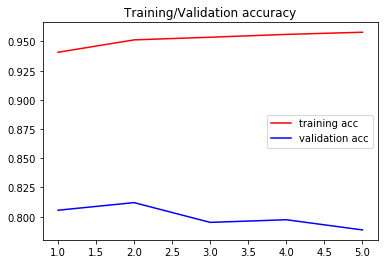

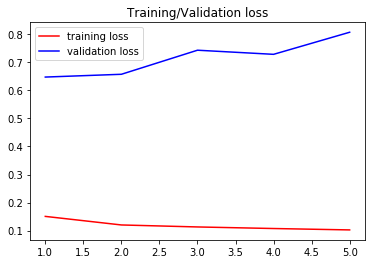

In [ ]:
plot_graphs(history_gru)

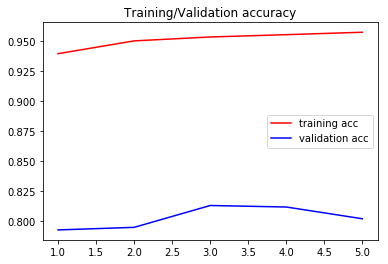

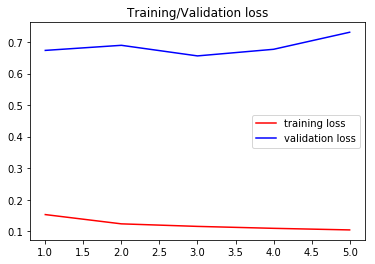

In [ ]:
plot_graphs(history_lstm)